In [ ]:
!pip install IProgress

In [ ]:
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
import IProgress
import ipywidgets
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import matplotlib.pyplot as plt
import random
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from itertools import product, combinations
from tqdm import tqdm
import joblib
from sklearn.ensemble import RandomForestClassifier

In [ ]:
seed = 2021

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving german_credit_prepared.csv to german_credit_prepared.csv


In [ ]:
credit = pd.read_csv("german_credit_prepared.csv", sep=",", engine="python")
#credit = pd.read_csv("Data/german_credit_prepared.csv", sep=",", engine="python")

input_types = {'account_check_status': "cat",
               'duration_in_month': "num",
               'credit_history': "cat", 
               'purpose': "cat", 
               'credit_amount': "num", 
               'savings': "cat",
               'present_emp_since': "cat",
               'installment_as_income_perc': "num",
               'sex': "cat",
               'personal _status': "cat",
               'other_debtors': "cat", 
               'present_res_since': "num", 
               'property': "cat",
               'age': "num", 
               'other_installment_plans': "cat", 
               'housing': "cat", 
               'credits_this_bank': "num", 
               'job': "cat",
               'people_under_maintenance': "num", 
               'telephone': "cat", 
               'foreign_worker': "cat"}

In [ ]:
y = credit['default']
X = credit.drop(columns="default")

# Define which columns should be encoded vs scaled
categorical_features = [col for col in X.columns if credit[col].dtype==object]
ordinal_features = [col for col in X.columns if credit[col].dtype==int]

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('ord', StandardScaler(), ordinal_features)
    ])

model = Pipeline(
        [
            ('preprocession', preprocessor),
            ('logreg', LogisticRegression())
        ]
)

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, random_state=seed)

In [ ]:
logreg = model.fit(X_train, y_train)

In [ ]:
def mesure_reg(reg, X_test, y_test):
    y_test_pred = reg.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)
    total=sum(sum(cm))
    sensitivity_recall = cm[0,0]/(cm[0,0]+cm[1,0])
    print('Sensitivity_recall : ',sensitivity_recall )
    Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
    print('Specificity: ', Specificity)
    precision = cm[0,0]/(cm[0,0]+cm[0,1])
    print('Precision: ', precision)
    accuracy =(cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
    print('Accuracy: ', accuracy)
    
    title = 'Matrice de confusion de la régression logistique'
    disp = plot_confusion_matrix(reg,
                                 X_test,
                                 y_test,
                                 cmap=plt.cm.Blues)
    disp.ax_.set_title(title)
    plt.show()

Sensitivity_recall :  0.7880794701986755
Specificity:  0.5714285714285714
Precision:  0.85
Accuracy:  0.735


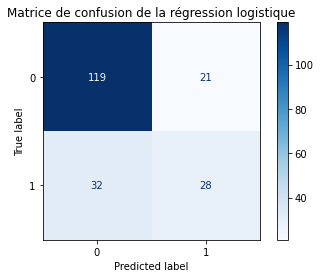

In [ ]:
mesure_reg(logreg, X_test, y_test)

# Evasion

On va chercher les variables non vérifiables et les modifiées jusqu'à ce que l'individu refusé soit accepté.

[Source](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data))

On voit qu'il n'y a que très peu de variables que l'on peut modifier et qui ne soit pas vérifiable. C'est une base de données pour crédit ce qui explique cela.
On voit qu'il y a :
 - purpose : correspond à la finalité du prêt
 - personal_status : la condition de vie en couple

On a également des variables difficilements vérifiables :
 - present_emp_since : depuis quand la personne travail à son poste
 - job : le type de travaille de la personne
 - people_under_maintenance : le nombre de personne à charge
 
On choisit ensuite une personne aléatoirement parmis les personnes refusées :

In [ ]:
#np.random.seed(seed)
idx_ref = np.where(logreg.predict_proba(X)[:, 1] > 0.5)[0]
idx = np.random.choice(idx_ref)

#idx = 153 # --> juste besoin de changer le but du prêt : 'education', '(vacation - does not exist?)', 'car (new)'
#idx = 232 #--> pas possible de le faire passer
X.iloc[idx]

account_check_status                                                     < 0 DM
duration_in_month                                                             9
credit_history                         existing credits paid back duly till now
purpose                                                               car (new)
credit_amount                                                               654
savings                                                            ... < 100 DM
present_emp_since                                            1 <= ... < 4 years
installment_as_income_perc                                                    4
sex                                                                        male
personal _status                                                         single
other_debtors                                                              none
present_res_since                                                             3
property                      if not A12

In [ ]:
logreg.predict_proba(X.iloc[idx].to_frame().transpose())[:, 1]

array([0.51808361])

In [ ]:
var_values = ['purpose', 'personal _status', 'present_emp_since', 'job', 'people_under_maintenance']
fix_values = [x for x in X.columns if x not in var_values]

all_values = [X[col].unique() for col in var_values]
prod = list(product(*all_values))   #produit cartésien

all_X = pd.DataFrame([X.iloc[idx][fix_values].tolist() + list(p) for p in prod],
                      columns=fix_values + var_values)
all_X = all_X[X.columns]
all_X['proba'] = logreg.predict_proba(all_X)[:, 1]

In [ ]:
all_X.sort_values('proba', inplace=True)
valid_X = all_X[all_X.proba < 0.5]

# On calcule le nombre de variable qu'on a du modifier
valid_X = valid_X.assign(diff = [(valid_X.iloc[i][var_values] == X.iloc[idx][var_values]).value_counts()[False] 
                                       for i in range(len(valid_X))])

valid_X.sort_values(by=['diff', 'proba'], inplace=True)
valid_X.head(5)

,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,sex,personal _status,other_debtors,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker,proba,diff
490,< 0 DM,9,existing credits paid back duly till now,car (used),654,... < 100 DM,1 <= ... < 4 years,4,male,single,none,3,"if not A121/A122 : car or other, not in attrib...",28,none,own,1,unskilled - resident,1,none,yes,0.153898,1
1090,< 0 DM,9,existing credits paid back duly till now,retraining,654,... < 100 DM,1 <= ... < 4 years,4,male,single,none,3,"if not A121/A122 : car or other, not in attrib...",28,none,own,1,unskilled - resident,1,none,yes,0.279378,1
970,< 0 DM,9,existing credits paid back duly till now,furniture/equipment,654,... < 100 DM,1 <= ... < 4 years,4,male,single,none,3,"if not A121/A122 : car or other, not in attrib...",28,none,own,1,unskilled - resident,1,none,yes,0.292198,1
10,< 0 DM,9,existing credits paid back duly till now,domestic appliances,654,... < 100 DM,1 <= ... < 4 years,4,male,single,none,3,"if not A121/A122 : car or other, not in attrib...",28,none,own,1,unskilled - resident,1,none,yes,0.303239,1
610,< 0 DM,9,existing credits paid back duly till now,business,654,... < 100 DM,1 <= ... < 4 years,4,male,single,none,3,"if not A121/A122 : car or other, not in attrib...",28,none,own,1,unskilled - resident,1,none,yes,0.341848,1


In [ ]:
def print_diff(new_comb, old_comb):
    diff_comb = (new_comb != old_comb)
    diff_pd = pd.DataFrame([old_comb[diff_comb], new_comb[diff_comb]], index=['old', 'new']).transpose()

    max_ind = max([len(x) for x in diff_pd.index])
    max_old = max([len(x) for x in diff_pd.old])
    max_new = max([len(x) for x in diff_pd.new])

    for i in new_comb[diff_comb].index :
        print(f'{i:<{max_ind}} : {diff_pd.old[i]:<{max_old}} --> {diff_pd.new[i]:<{max_new}}')

In [ ]:
print_diff(valid_X.iloc[0][var_values], X.iloc[idx][var_values])

purpose : car (new) --> car (used)


In [ ]:
X_ref = X.loc[idx_ref]

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving all_X.csv to all_X.csv


In [ ]:
#all_X = pd.DataFrame([X.iloc[idx][fix_values].tolist() + list(p)  + [idx] for idx in tqdm(idx_ref) for p in prod],
#                         columns=fix_values + var_values + ['index_old'])
#all_X[list(X.columns) + ['index_old']].to_csv('all_X.csv', index=False)
all_X = pd.read_csv('all_X.csv')
#all_X = pd.read_csv('Data/all_X.csv')
all_X['proba'] = logreg.predict_proba(all_X.drop('index_old', axis=1))[:, 1]

X_false = X.loc[idx_ref]
X_false = X_false.assign(proba = logreg.predict_proba(X_false)[:, 1])

X_false = X_false.assign(proba_min = all_X.groupby('index_old').apply(lambda x: x.sort_values('proba').head(1)) \
                                                                .set_index('index_old').proba)

In [ ]:
len(X_false)

231

In [ ]:
len(X_false[X_false.proba_min < 0.5])

222

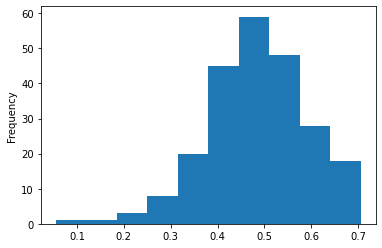

In [ ]:
(X_false.proba - X_false.proba_min).plot.hist()
plt.show()

In [ ]:
X_false[X_false.proba_min >= 0.5]

,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,sex,personal _status,...,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker,proba,proba_min
29,< 0 DM,60,delay in paying off in the past,business,6836,... < 100 DM,.. >= 7 years,3,male,single,...,63,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes,0.860025,0.510119
95,0 <= ... < 200 DM,54,no credits taken/ all credits paid back duly,business,15945,... < 100 DM,... < 1 year,3,male,single,...,58,none,rent,1,skilled employee / official,1,"yes, registered under the customers name",yes,0.925281,0.646397
374,0 <= ... < 200 DM,60,all credits at this bank paid back duly,furniture/equipment,14782,100 <= ... < 500 DM,.. >= 7 years,3,female,divorced,...,60,bank,for free,2,management/ self-employed/ highly qualified em...,1,"yes, registered under the customers name",yes,0.955069,0.725386
538,< 0 DM,48,existing credits paid back duly till now,car (new),7763,... < 100 DM,.. >= 7 years,4,male,single,...,42,bank,for free,1,management/ self-employed/ highly qualified em...,1,none,yes,0.936464,0.611765
714,0 <= ... < 200 DM,60,existing credits paid back duly till now,car (new),14027,... < 100 DM,4 <= ... < 7 years,4,male,single,...,27,none,own,1,management/ self-employed/ highly qualified em...,1,"yes, registered under the customers name",yes,0.932725,0.701115
728,0 <= ... < 200 DM,48,all credits at this bank paid back duly,business,6416,... < 100 DM,.. >= 7 years,4,female,divorced,...,59,none,rent,1,skilled employee / official,1,none,yes,0.941864,0.550679
832,< 0 DM,45,no credits taken/ all credits paid back duly,business,11816,... < 100 DM,.. >= 7 years,2,male,single,...,29,none,rent,2,skilled employee / official,1,none,yes,0.868788,0.528786
927,< 0 DM,48,existing credits paid back duly till now,car (used),10297,... < 100 DM,4 <= ... < 7 years,4,male,single,...,39,stores,for free,3,skilled employee / official,2,"yes, registered under the customers name",yes,0.747218,0.691652
973,< 0 DM,60,existing credits paid back duly till now,business,7297,... < 100 DM,.. >= 7 years,4,male,single,...,36,none,rent,1,skilled employee / official,1,none,yes,0.943129,0.737575


# Poisoning

On remarque qu'il y a certaine personne pour qui la modification de variables difficilement vérifiables n'est pas suffisant. 
On passe donc à la deuxième attaque *poisoning*. On a vu précédemment que l'individu *232* fait partie des personnes ne pouvant pas utiliser la triche pour pouvoir être accepté.

On va rajouter sa ligne dans la base de donnée d'entrainement et voir si cela a un impact.

In [ ]:
y = credit['default']
X = credit.drop(columns="default")

ind = X.iloc[[95]]

In [ ]:
ind

,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,sex,personal _status,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
95,0 <= ... < 200 DM,54,no credits taken/ all credits paid back duly,business,15945,... < 100 DM,... < 1 year,3,male,single,...,4,unknown / no property,58,none,rent,1,skilled employee / official,1,"yes, registered under the customers name",yes


In [ ]:
n = 8
X_train_pois = X_train.append([ind]*n, ignore_index=True)
y_train_pois = pd.Series(list(y_train) + [0]*n)

Sensitivity_recall :  0.7880794701986755
Specificity:  0.5714285714285714
Precision:  0.85
Accuracy:  0.735


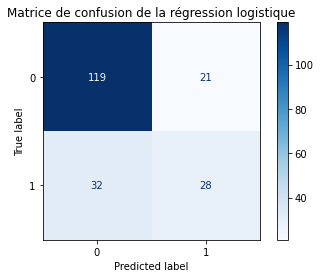

In [ ]:
logreg = model.fit(X_train, y_train)

mesure_reg(logreg, X_test, y_test)

In [ ]:
logreg.predict_proba(ind)[0,1]

0.9252811288880369

Sensitivity_recall :  0.7792207792207793
Specificity:  0.5652173913043478
Precision:  0.8571428571428571
Accuracy:  0.73


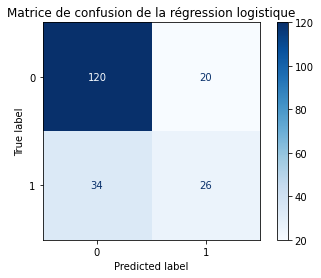

In [ ]:
logreg_pois = model.fit(X_train_pois, y_train_pois)

mesure_reg(logreg_pois, X_test, y_test)

In [ ]:
logreg_pois.predict_proba(ind)[0,1]

0.47792864829500725

On automatise la recherche du nombre minimum de copie pour passer.

In [ ]:
def min_pois(ind):
    n = 0
    X_train_pois = X_train
    y_train_pois = y_train
    
    while model.fit(X_train_pois, y_train_pois).predict_proba(ind)[0,1] > 0.5:
        n += 1
        X_train_pois = X_train_pois.append([ind], ignore_index=True)
        y_train_pois = pd.Series(list(y_train_pois) + [0])
        
    return n

In [ ]:
min_pois(ind)

8

On regarde la distribution pour les personnes qui ont besoin du poisoning

In [ ]:
%%capture
list_min = X_false[X_false.proba_min > 0.5].apply(lambda x: min_pois(x.to_frame().transpose()), axis=1)

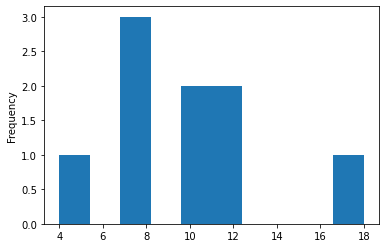

In [ ]:
list_min.plot.hist()
plt.show()

On peut coupler les deux premières attaques pour avoir encore moins de copie à rajouter.

In [ ]:
ind_best_comb = all_X[all_X['index_old'] == ind.index[0]].sort_values(by='proba').head(1)  \
                                            .drop(['index_old', 'proba'], axis=1)

In [ ]:
print_diff(ind_best_comb.iloc[0], ind.iloc[0])

purpose           : business                    --> car (used)                                                   
present_emp_since : ... < 1 year                --> 4 <= ... < 7 years                                           
job               : skilled employee / official --> management/ self-employed/ highly qualified employee/ officer


In [ ]:
n = 2
X_train_pois_best = X_train.append([ind_best_comb]*n, ignore_index=True)
y_train_pois_best = pd.Series(list(y_train) + [0]*n)

Sensitivity_recall :  0.7828947368421053
Specificity:  0.5625
Precision:  0.85
Accuracy:  0.73


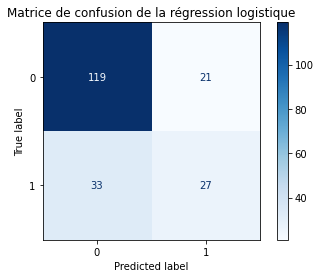

In [ ]:
logreg_pois_best = model.fit(X_train_pois_best, y_train_pois_best)

mesure_reg(logreg_pois_best, X_test, y_test)

In [ ]:
logreg_pois_best.predict_proba(ind_best_comb)[0,1]

0.47038082777460294

On automatise

In [ ]:
def min_pois_best_comb(ind, print_chan=True):
    ind_best_comb = all_X[all_X['index_old'] == ind.index[0]].sort_values(by='proba').head(1)  \
                                            .drop(['index_old', 'proba'], axis=1)

    print_diff(ind_best_comb.iloc[0], ind.iloc[0]) if print_chan else ...
    
    n = 0
    X_train_pois = X_train
    y_train_pois = y_train
    
    while model.fit(X_train_pois, y_train_pois).predict_proba(ind_best_comb)[0,1] > 0.5:
        n += 1
        X_train_pois = X_train_pois.append([ind_best_comb], ignore_index=True)
        y_train_pois = pd.Series(list(y_train_pois) + [0])
        
    return n

In [ ]:
min_pois_best_comb(ind)

purpose           : business                    --> car (used)                                                   
present_emp_since : ... < 1 year                --> 4 <= ... < 7 years                                           
job               : skilled employee / official --> management/ self-employed/ highly qualified employee/ officer


2

In [ ]:
%%capture
list_min_best_comb = X_false[X_false.proba_min > 0.5].apply(lambda x: 
                                                            min_pois_best_comb(x.to_frame().transpose(), False), axis=1)

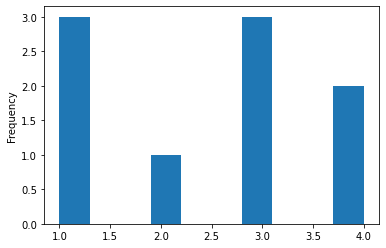

In [ ]:
list_min_best_comb.plot.hist()
plt.show()

# Model extraction

Le but de cette attaque est de réccupérer les poids d'un modèle.
On suppose que l'on connait l'architechure : regression logistique.

Ce que l'on va faire c'est créer des nouvelles entrées que l'on va donné à notre modèle blackbox qui va les labélisé puis on va utilser ces labels pour entrainer notre nouveau modèle.

In [ ]:
def new_entries(n):
    list_entries = []
    for col in X.columns:
        list_entries.append(np.random.choice(X[col].unique(), n, p=(X[col].value_counts()/1000).to_numpy()))
    return pd.DataFrame(np.array(list_entries).transpose(), columns=X.columns)

In [ ]:
n = len(X_train)
X_new = new_entries(n)
y_new = logreg.predict(X_new)

Sensitivity_recall :  0.7880794701986755
Specificity:  0.5714285714285714
Precision:  0.85
Accuracy:  0.735


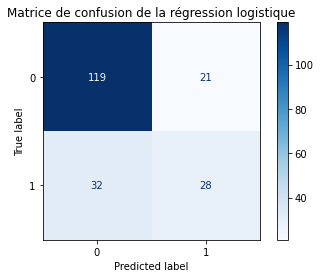

In [ ]:
mesure_reg(model.fit(X_train, y_train), X_test, y_test)

Sensitivity_recall :  0.7806451612903226
Specificity:  0.5777777777777777
Precision:  0.8642857142857143
Accuracy:  0.735


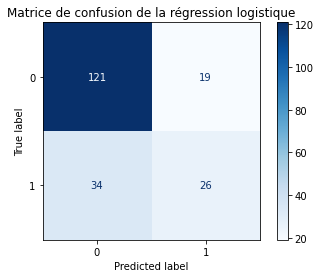

In [ ]:
mesure_reg(model.fit(X_new, y_new), X_test, y_test)

In [ ]:
def new_entries_unif(n):
    list_entries = []
    for col in X.columns:
        list_entries.append(np.random.choice(X[col].unique(), n))
    return pd.DataFrame(np.array(list_entries).transpose(), columns=X.columns)

In [ ]:
n = len(X_train)
X_new_unif = new_entries_unif(n)
logreg = model.fit(X_train, y_train)
y_new_unif = logreg.predict(X_new_unif)

Sensitivity_recall :  0.7973856209150327
Specificity:  0.6170212765957447
Precision:  0.8714285714285714
Accuracy:  0.755


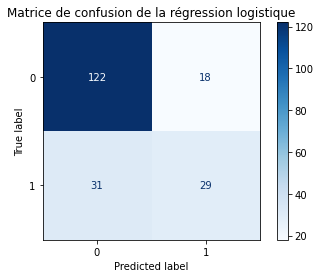

In [ ]:
mesure_reg(model.fit(X_new_unif, y_new_unif), X_test, y_test)

Mesure de distance :
 - l'accuracy : mesure de l'efficacité de l'apprentissage
 - la précision : mesure de la distance du modèle original

In [ ]:
y_hat = model.fit(X_new, y_new).predict(X_test)
y_ori = model.fit(X_train, y_train).predict(X_test)

prec = (y_ori == y_hat).astype(int).sum()/len(y_ori)
accu_diff = accuracy_score(y_test, y_ori) - accuracy_score(y_test, y_hat)
print(f"Précision : {prec:.3f}, Différence d'accuracy : {accu_diff:.3f}")

Précision : 0.940, Différence d'accuracy : 0.000


In [ ]:
y_hat = model.fit(X_new_unif, y_new_unif).predict(X_test)
y_ori = model.fit(X_train, y_train).predict(X_test)

prec = (y_ori == y_hat).astype(int).sum()/len(y_ori)
accu_diff = accuracy_score(y_test, y_ori) - accuracy_score(y_test, y_hat)
print(f"Précision : {prec:.3f}, Différence d'accuracy : {accu_diff:.3f}")

Précision : 0.960, Différence d'accuracy : -0.020


# Trouver un modèle capable de surapprendre

In [ ]:
def add_relations(df_orig):
    df = df_orig.copy()
    for i, j in combinations(categorical_features, 2):
        df[i + j] = df[i] + df[j]
    return df

new_categorical_features = categorical_features + [i + j for i, j in combinations(categorical_features, 2)]


# On normalise les colones dans leur noms
all_values = [X[col].unique() for col in categorical_features]
categorie_rel = list(combinations(all_values, 2))

categorie_name = [a + b for a,b in combinations(categorical_features, 2)]
categorie_values = [[a + b for a,b in list(product(*x))] for x in categorie_rel]

preprocessor_comb = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(categories=all_values+categorie_values, drop='first'), new_categorical_features),
        ('ord', StandardScaler(), ordinal_features)
    ])

model_over = Pipeline(
    steps=[
        ('relations', FunctionTransformer(add_relations)), 
        ('preprocession', preprocessor_comb),
        ('logreg', LogisticRegression(max_iter=200))
    ]
)

In [ ]:
%timeit model.fit(X_train, y_train)
print(f"validation : {model.score(X_test, y_test):.3f}, score : {model.score(X_train, y_train):.3f}") 

27.7 ms ± 1.65 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
validation : 0.735, score : 0.787


In [ ]:
%timeit model_over.fit(X_train, y_train)
print(f"validation : {model_over.score(X_test, y_test):.3f}, score : {model_over.score(X_train, y_train):.3f}") 

153 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
validation : 0.725, score : 0.958


On a donc de l'overfit 

# Proprety inference

On va chercher a reccupérer la proportion homme/femme de la base de donnée d'entrainement

In [ ]:
def new_entries_homme(n, homme=True):
    list_entries = []
    for col in X.columns:
        if col == 'sex':
            q = max(0, min(0.6 + np.random.normal(scale=0.1), 1))
            proba = [q, 1-q]
            proba.sort(reverse=homme)
            list_entries.append(np.random.choice(['male', 'female'], n, p=proba))
        else:
            list_entries.append(np.random.choice(X[col].unique(), n, p=(X[col].value_counts()/1000).to_numpy()))
    return pd.DataFrame(np.array(list_entries).transpose(), columns=X.columns)

In [ ]:
new_entries_homme(1000).sex.value_counts(normalize=True)

male      0.512
female    0.488
Name: sex, dtype: float64

In [ ]:
n = 300
m = len(X_train)

model.fit(X_train, y_train)

data_X = [x for _ in tqdm(range(n//2)) for x in (new_entries_homme(m, True), new_entries_homme(m, False))]
data_y = model.predict(pd.DataFrame(np.array(data_X).reshape(-1, 21), columns=X.columns)).reshape(n, -1)

data_res = [model_over.fit(data_X[i], data_y[i])['logreg'].coef_[0] for i in tqdm(range(len(data_X)))]
#data_res = [model.fit(data_X[i], data_y[i])['logreg'].coef_[0] for i in tqdm(range(len(data_X)))]
data_res_homme = np.array([x for _ in range(n//2) for x in [1, 0]])

100%|██████████| 300/300 [00:46<00:00,  6.51it/s]


In [ ]:
dist_homme = [(x.sex.value_counts(normalize=True))['male'] for x in data_X]

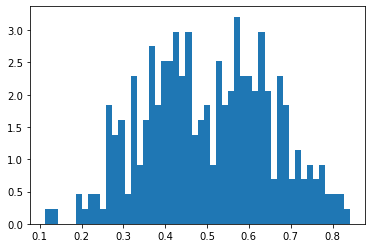

In [ ]:
plt.hist(dist_homme, density=True, bins=50)
plt.show()

In [ ]:
X_train_super, X_test_super, y_train_super, y_test_super = model_selection.train_test_split(data_res, 
                                                                                            data_res_homme, 
                                                                                            test_size=0.20, 
                                                                                            random_state=seed)
super_model = LogisticRegression(max_iter=200)
super_model.fit(X_train_super, y_train_super)

LogisticRegression(max_iter=200)

In [ ]:
confusion_matrix(y_test_super, super_model.predict(X_test_super))

array([[26,  2],
       [ 4, 28]])

In [ ]:
print(X_train.sex.value_counts(normalize=True))

# Attention j'ai utilisé la prédiction du modèle au lieu de y_train !!
#super_model.predict_proba(model_over.fit(X_train, y_train)['logreg'].coef_)
super_model.predict_proba(model_over.fit(X_train, model.predict(X_train))['logreg'].coef_)

male      0.6925
female    0.3075
Name: sex, dtype: float64


array([[0.15704897, 0.84295103]])

In [ ]:
data_res_prop = [(x.sex.value_counts(normalize=True))['male'] for x in data_X]
X_train_super, X_test_super, y_train_super, y_test_super = model_selection.train_test_split(data_res, 
                                                                                            data_res_prop, 
                                                                                            test_size=0.20, 
                                                                                            random_state=seed)

In [ ]:
super_model_linear = LinearRegression()
super_model_linear.fit(X_train_super, y_train_super)

LinearRegression()

In [ ]:
((np.abs(y_test_super - super_model_linear.predict(X_test_super))/y_test_super) * 100).mean()

17.284295026464985

In [ ]:
super_model_linear.predict(model_over.fit(X_train, model.predict(X_train))['logreg'].coef_)

array([0.69545994])

In [ ]:
from sklearn import svm

super_model_svr = svm.LinearSVR(max_iter=2000)
super_model_svr.fit(X_train_super, y_train_super)

LinearSVR(max_iter=2000)

In [ ]:
((np.abs(y_test_super - super_model_svr.predict(X_test_super))/y_test_super) * 100).mean()

17.155981711730142

In [ ]:
super_model_svr.predict(model_over.fit(X_train, model.predict(X_train))['logreg'].coef_)

array([0.68429442])

# Differential Privacy

On va implementer la regression logistique en tensorflow

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy

In [ ]:
number_of_classes = 1
number_of_features = 1334

X_train_pre = preprocessor_comb.transform(add_relations(X_train)).toarray().astype(np.float32)
X_test_pre = preprocessor_comb.transform(add_relations(X_test)).toarray().astype(np.float32)

In [ ]:
# Sans Differential Privacy

opt = Adam()
loss = BinaryCrossentropy()
es = EarlyStopping(monitor='val_loss')

model = Sequential()
model.add(Dense(number_of_classes, activation = 'sigmoid', input_dim = number_of_features))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=BinaryAccuracy(dtype=None, threshold=0.5))

model.fit(X_train_pre, y_train.to_numpy(), epochs=50, 
          validation_data=(X_test_pre, y_test.to_numpy()), callbacks=es)

Epoch 1/50
25/25 [==============================] - 0s 6ms/step - loss: 0.6701 - binary_accuracy: 0.6292 - val_loss: 0.6116 - val_binary_accuracy: 0.7000
Epoch 2/50
25/25 [==============================] - 0s 2ms/step - loss: 0.6129 - binary_accuracy: 0.6673 - val_loss: 0.5729 - val_binary_accuracy: 0.7150
Epoch 3/50
25/25 [==============================] - 0s 2ms/step - loss: 0.5213 - binary_accuracy: 0.7566 - val_loss: 0.5491 - val_binary_accuracy: 0.7200
Epoch 4/50
25/25 [==============================] - 0s 2ms/step - loss: 0.4931 - binary_accuracy: 0.7680 - val_loss: 0.5327 - val_binary_accuracy: 0.7250
Epoch 5/50
25/25 [==============================] - 0s 2ms/step - loss: 0.4867 - binary_accuracy: 0.7718 - val_loss: 0.5234 - val_binary_accuracy: 0.7200
Epoch 6/50
25/25 [==============================] - 0s 3ms/step - loss: 0.4748 - binary_accuracy: 0.7774 - val_loss: 0.5188 - val_binary_accuracy: 0.7250
Epoch 7/50
25/25 [==============================] - 0s 3ms/step - loss: 0.43

In [ ]:
from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras_vectorized import make_vectorized_keras_optimizer_class
from tensorflow.keras.losses import BinaryCrossentropy, Reduction

In [ ]:
# Avec Differential Privacy

l2_norm_clip = 1.0
noise_multiplier = 0.5
num_microbatches = 1

opt = make_vectorized_keras_optimizer_class(Adam)(l2_norm_clip=l2_norm_clip, 
                                                  noise_multiplier=noise_multiplier, 
                                                  num_microbatches=num_microbatches)
loss = BinaryCrossentropy(reduction=Reduction.NONE) #pourquoi neduction.None
es = EarlyStopping(monitor='val_loss')

model_diff = Sequential()
model_diff.add(Dense(number_of_classes, activation = 'sigmoid', input_dim = number_of_features))
model_diff.compile(optimizer=opt, loss=loss, metrics=BinaryAccuracy(dtype=None, threshold=0.5))

model_diff.fit(X_train_pre, y_train.to_numpy(), epochs=50,
               validation_data=(X_test_pre, y_test.to_numpy()), callbacks=es)

Epoch 1/50
25/25 [==============================] - 1s 6ms/step - loss: 0.7545 - binary_accuracy: 0.4114 - val_loss: 0.7219 - val_binary_accuracy: 0.4650
Epoch 2/50
25/25 [==============================] - 0s 2ms/step - loss: 0.7217 - binary_accuracy: 0.4571 - val_loss: 0.6920 - val_binary_accuracy: 0.5200
Epoch 3/50
25/25 [==============================] - 0s 3ms/step - loss: 0.6912 - binary_accuracy: 0.5306 - val_loss: 0.6719 - val_binary_accuracy: 0.5600
Epoch 4/50
25/25 [==============================] - 0s 2ms/step - loss: 0.6675 - binary_accuracy: 0.6060 - val_loss: 0.6528 - val_binary_accuracy: 0.6650
Epoch 5/50
25/25 [==============================] - 0s 2ms/step - loss: 0.6554 - binary_accuracy: 0.6083 - val_loss: 0.6358 - val_binary_accuracy: 0.6750
Epoch 6/50
25/25 [==============================] - 0s 3ms/step - loss: 0.6299 - binary_accuracy: 0.6687 - val_loss: 0.6236 - val_binary_accuracy: 0.6800
Epoch 7/50
25/25 [==============================] - 0s 3ms/step - loss: 0.62

In [ ]:
model = Sequential()
model.add(Dense(number_of_classes, activation = 'sigmoid', input_dim = number_of_features))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=BinaryAccuracy(dtype=None, threshold=0.5))

%timeit model.fit(X_train_pre, y_train.to_numpy(), epochs=50, \
                  validation_data=(X_test_pre, y_test.to_numpy()), callbacks=es, \
                  verbose=0)

229 ms ± 31.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
model_diff = Sequential()
model_diff.add(Dense(number_of_classes, activation = 'sigmoid', input_dim = number_of_features))
model_diff.compile(optimizer=opt, loss=loss, metrics=BinaryAccuracy(dtype=None, threshold=0.5))

%timeit model_diff.fit(X_train_pre, y_train.to_numpy(), epochs=50, \
                       validation_data=(X_test_pre, y_test.to_numpy()), callbacks=es, \
                       verbose=0)

391 ms ± 193 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
y_pred = (model.predict(X_test_pre) > 0.5).astype("int32")
y_test_pre = y_test.to_numpy().reshape((-1,1))

print(confusion_matrix(y_test_pre, y_pred))

[[125  15]
 [ 32  28]]


In [ ]:
y_pred = (model_diff.predict(X_test_pre) > 0.5).astype("int32")
y_test_pre = y_test.to_numpy().reshape((-1,1))

print(confusion_matrix(y_test_pre, y_pred))

[[127  13]
 [ 37  23]]


# Membership attack

In [ ]:
from mia.estimators import ShadowModelBundle, AttackModelBundle, prepare_attack_data
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
prep_over = Pipeline(
    steps=[
        ('relations', FunctionTransformer(add_relations)), 
        ('preprocession', preprocessor_comb),
    ]
)

In [ ]:
n = 10000

X_attaquant = new_entries(n)
y_attaquant = model_over.fit(X_train, y_train).predict(X_attaquant)

X_attaquant_proc = prep_over.fit_transform(X_attaquant)

In [ ]:
smb = ShadowModelBundle(
    lambda : LogisticRegression(max_iter=300),
    shadow_dataset_size=1000,
    num_models=50
    )

In [ ]:
X_shadow, y_shadow = smb.fit_transform(X_attaquant_proc, y_attaquant)

In [ ]:
def attack_model_fn():
    """Attack model that takes target model predictions and predicts membership.
    Following the original paper, this attack model is specific to the class of the input.
    AttachModelBundle creates multiple instances of this model for each class.
    """
    model = tf.keras.models.Sequential()

    model.add(layers.Dense(128, activation="relu", input_shape=(2,)))

    model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2, noise_shape=None, seed=None))
    model.add(layers.Dense(64, activation="relu"))

    model.add(layers.Dense(1, activation="sigmoid"))
    model.compile("adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


In [ ]:
amb = AttackModelBundle(attack_model_fn, num_classes=2)

In [ ]:
 # Fit the attack models.
print("Training the attack models...")
amb.fit(
    X_shadow, y_shadow, fit_kwargs=dict(epochs=10, verbose=True)
)

Training the attack models...
Epoch 1/10
3125/3125 [==============================] - 3s 887us/step - loss: 0.6753 - accuracy: 0.5530
Epoch 2/10
3125/3125 [==============================] - 3s 927us/step - loss: 0.6661 - accuracy: 0.5634
Epoch 3/10
3125/3125 [==============================] - 3s 950us/step - loss: 0.6665 - accuracy: 0.5651
Epoch 4/10
3125/3125 [==============================] - 3s 993us/step - loss: 0.6669 - accuracy: 0.5648
Epoch 5/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.6651 - accuracy: 0.5660
Epoch 6/10
3125/3125 [==============================] - 3s 1ms/step - loss: 0.6647 - accuracy: 0.5667
Epoch 7/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.6646 - accuracy: 0.5687
Epoch 8/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.6649 - accuracy: 0.5655
Epoch 9/10
3125/3125 [==============================] - 4s 1ms/step - loss: 0.6651 - accuracy: 0.5655
Epoch 10/10
3125/3125 [=====================

ValueError: Expect x to be a non-empty array or dataset.

## Formules

Le problème dans ce que vous avez écrit y'a une surparamétrisation :

On peut pas avoir P(X=F|Y=1) = 0,8 avec P(Y=1|X=F) = 0,7, P(Y=1|X=H) = 0,6 et P(X=H) = 0,5


En gros l'association à trouver P(X=F|Y=1) = 0.8 avec une certaine base de donnée et on ne peut pas utiliser ce résultat avec les autre proba qui sont trouvé avec une autre base. 


Si on utilise les résultats de l'API on trouve P(X=F|Y=1) = 0,5385

In [ ]:
def new_entries_femme(n, p):
    list_entries = []
    for col in X.columns:
        if col == 'sex':
            proba = [1-p, p]
            list_entries.append(np.random.choice(['male', 'female'], n, p=proba))
        else:
            list_entries.append(np.random.choice(X[col].unique(), n, p=(X[col].value_counts()/1000).to_numpy()))
    return pd.DataFrame(np.array(list_entries).transpose(), columns=X.columns)

In [ ]:
p_femme = 0.7543

X_0 = new_entries_femme(1000000, p_femme)
y_0 = model.predict(X_0)

X_0['defaut'] = y_0

In [ ]:
p_defaut_homme = X_0[(X_0.sex == 'male')].defaut.value_counts(normalize=True)[1]
p_defaut_femme = X_0[(X_0.sex == 'female')].defaut.value_counts(normalize=True)[1]
p_femme_defaut = X_0[X_0.defaut == 1].sex.value_counts(normalize=True)['female']

p_femme = p_femme_defaut * ((1-p_femme) * p_defaut_homme + p_femme * p_defaut_femme) / p_defaut_femme
print(f'{p_femme:.4f}')

0.7543


In [ ]:
p_defaut_femme = 0.7
p_defaut_homme = 0.6
p_homme = 0.5
p_femme = 1 - p_homme
p_defaut = p_homme * p_defaut_homme + p_femme * p_defaut_femme

p_femme_defaut = p_femme * p_defaut_femme / p_defaut
print(f'{p_femme_defaut:.4f}')

0.5385
